In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import *
from commando.utilities import predict_nn
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-09-15 04:46:15.279908: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-15 04:46:15.279937: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

In [4]:
import scanpy as sc

babel_dir = '../babel_data/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix/'
train = sc.read_h5ad(babel_dir + 'train_rna.h5ad')
v = train.var_names
train = train.X.toarray()
valid = sc.read_h5ad(babel_dir + 'truth_rna.h5ad').X.toarray()
data1 = np.concatenate([train, valid], axis=0)
fnames1 = np.array(v)

train = sc.read_h5ad(babel_dir + 'train_atac.h5ad')
v = train.var_names
train = train.X.toarray()
valid = sc.read_h5ad(babel_dir + 'truth_atac.h5ad').X.toarray()
data2 = np.concatenate([train, valid], axis=0)
fnames2 = np.array(v)

split = train.shape[0]

/home/thema/miniconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/thema/miniconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [5]:
dataset_name = 'pbmc'
modality_names = ['RNA', 'ATAC']

# data1 = PCA(n_components=32).fit_transform(data1)
# data2 = PCA(n_components=32).fit_transform(data2)
# fnames1 = fnames2 = None

type1 = np.array(len(data1) * ['Cell Type 0'])
type2 = np.array(len(data2) * ['Cell Type 0'])

# Sampling
sample_num = split
data_col_idx = np.random.choice(range(split), sample_num, replace=False)
data1, data2, type1, type2 = (x[list(data_col_idx) + list(range(split, len(data1)))] for x in (data1, data2, type1, type2))
split = sample_num

# Labels
labels = [type1, type2]
features = [list(fnames1), list(fnames2)]

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
data1 = preprocessing.MinMaxScaler().fit_transform(data1)
data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = [f'Feature {i}' for i in range(dataset[i].shape[1])]

/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

In [6]:
# Train-Test Imputation
train_idx = np.array(list(range(split)))
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

In [7]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 32
batch_size = 32
pca_dim = [256] * 2
dist_method = 'euclidean'

# ComManDo

In [8]:
# Integration
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': int(1e7),
    'log_DNN': 500,
    'use_early_stop': True,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': dist_method,
}

In [9]:
# Imputation
cm_im = ComManDo(**kwargs)
cm_im.fit_transform(dataset=[data1[train_idx], data2[train_idx]])
cm_imputed = [cm_im.modal_predict(dataset[i][test_idx], i) for i in range(1, -1, -1)]

use random seed: 666
Shape of Raw data
Dataset 0: (8747, 34861)
Dataset 1: (8747, 86111)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:12.9150 alpha:10.0854
epoch:[1000/2000] err:0.0006 alpha:0.0004
epoch:[1500/2000] err:0.0000 alpha:0.0000
epoch:[2000/2000] err:0.0000 alpha:0.0000
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/10000000]: loss:1.097528
epoch:[1000/10000000]: loss:1.050569
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 1778.1324494520013
Correspondence: 38039.377393384
Mapping: 6426.849649819
Total: 46244.359492655



# Comparison Methods

In [10]:
# Imputation
if True:
    imputation_name = 'Babel'
    bdata1 = sc.read_h5ad(babel_dir + 'atac_rna_test_preds.h5ad').X.toarray()
    bdata2 = sc.read_h5ad(babel_dir + 'rna_atac_test_preds.h5ad').X.toarray()
    nn_imputed = [bdata1, bdata2]
else:
    imputation_name = 'NN'
    nn_imputed = [predict_nn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i][test_idx]).float()) for i in range(1, -1, -1)]

# Visualization

Samp, PCA

RNA imp

ATAC imp

--

8747, 256

In [11]:
imputed_data = [cm_imputed, nn_imputed][::-1]
imputed_names = ['JAMIE', imputation_name][::-1]
colors = ['blue', 'red', 'teal']
style='whitegrid'

sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

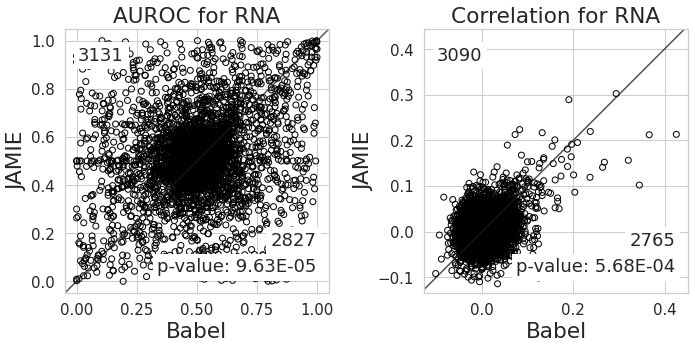

In [12]:
import warnings
plt.figure(figsize=(10, 5))
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp1.png')

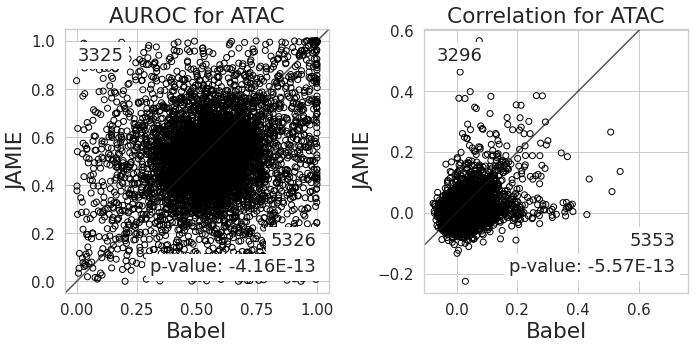

In [13]:
import warnings
plt.figure(figsize=(10, 5))
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp2.png')

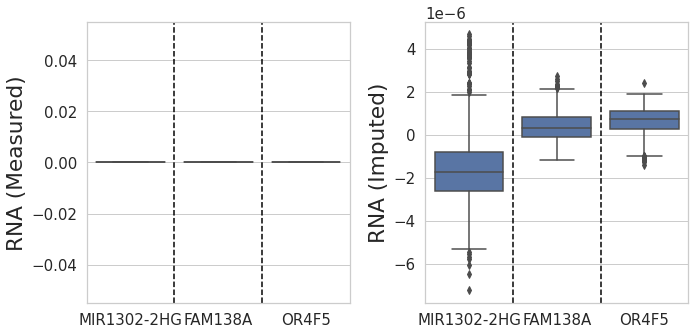

In [14]:
plt.figure(figsize=(10, 5))
plot_distribution([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], supert=modality_names[0], fnames=2*[features[0]])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Dist1.png')

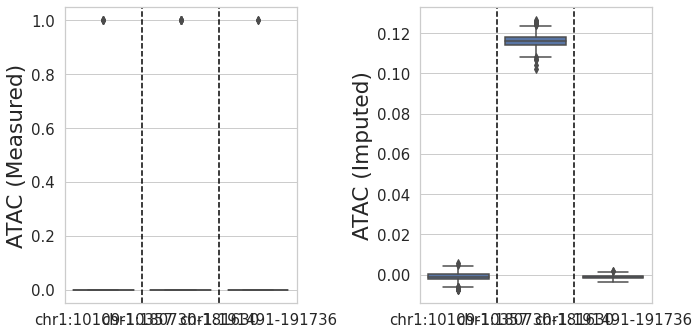

In [15]:
plt.figure(figsize=(10, 5))
plot_distribution([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], supert=modality_names[1], fnames=2*[features[1]])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Dist2.png')

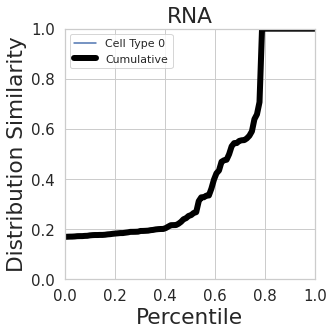

In [16]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], title=modality_names[0])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sim1.png')

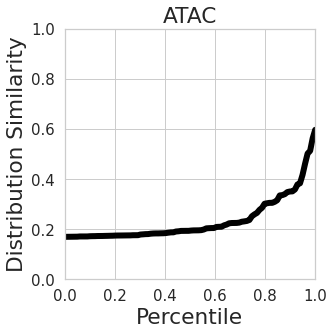

In [17]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], title=modality_names[1], legend=False)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sim2.png')